## Summative 

This exercise will go through a simulated streaming data workflow, as seen in the streaming data module. But it will be more complex, and closer to what a real world scenario might look like. You will need to 
- Investigate the incoming data
- Create an appropriate database to store the incoming records
- Write code to process records one by one as they arrive, including
- Printing warnings when any reading goes above a predefined threshold
- Storing the incoming data in a database
- Write code to analyse the stored data in a scalable manner
- Display relevant information in a dashboard

## Create an appropriate database

Each incoming record will look something like the following: 

{'Device_ID': 9,                  
  'Temp1': 33.01235436945101,  
  'Temp2': 46.313589806396116,  
  'Temp3': 16.506177184725505,  
  'Temp_Ambient': 23.782493817278034}
  
Each device is assigned an integer ID. Every device has multiple sensors, and reports the readings from each sensor as a float. Each call to gen_data.getReading() returns a time (an integer here to make things easier) and a record that follows the same pattern as above.

<b>Create a database to store the incoming data.</b> Include a time field for the time that the data arrives. If you create the database with python, show the code here, otherwise include any bash or sql code you run. You may wish to come back and add additional fields to make later analysis easier.

In [6]:
import pandas as pd
import numpy as np

## Store and process the incoming data

As each record arrives (i.e. each loop of the for loop), you must
- <b>Store the record in the database you created above
- Use either moving windows or exponential averaging to keep track each sensor value for each device. Print out the values at the end of the loop
- Print a warning if any reported temperature exceeds 100 degrees for the first time for that device</b>

In [ ]:
import gen_data 

window = [] # The moving window

db = pd.DataFrame(columns=['Time', 'Device_ID', 'Temp1', 'Temp2', 'Temp3','Temp_Ambient'])
ErroLogDevice = []

# Your code here for any initializations you may need

for i in range(20000): # Hint: make this lower for testing
    
    # The simulated data arriving - don't change this
    arrival_time, record = gen_data.getReading()
           
    window.append(record) # Add the record to our moving window
    
    if len(window)>10: # Keep the window size from growing beyond 10:
        
        del(window[0]) # If the window is >10 items, delete the oldest
   
    # And add the reading and calculated values to a database (or in this case just a pandas DataFrame)
    db = pd.concat([db, pd.DataFrame([{'Time': arrival_time, 'Device_ID': record['Device_ID'],'Temp1':record['Temp1'], 
                                       'Temp2':record['Temp2'],'Temp3':record['Temp3'], 'Temp_Ambient':record['Temp_Ambient']}])],
                                       ignore_index=True)
                                       
               
    if (record['Temp1'] > 100 or record['Temp2'] > 100 or record['Temp3'] > 100 or record['Temp_Ambient'] > 100):
         if record['Device_ID'] not in ErroLogDevice:
            ErroLogDevice.append(record['Device_ID'])
            print ("One of the sensors on device %s has reported temperature above 100 degrees" %record['Device_ID'])
          
     
        
db.head() # The first few rows

One of the sensors on device 10 has reported temperature above 100 degrees
One of the sensors on device 1 has reported temperature above 100 degrees
One of the sensors on device 3 has reported temperature above 100 degrees
One of the sensors on device 0 has reported temperature above 100 degrees


## Analyzing the stored data

You now have a nice big database. <b>Load it into spark for analysis.</b>

You are told that during the time the data was being collected, devices 3 and 10 had malfunctioning sensors - their temperature3 readings are all 200+. <b>Verify this.</b> Since the engineers knew about the faulty sensors, no harm has been done, but seeing those false readings in the historical data makes you unhappy. You decide to go the extra mile and replace these readings with slightly more believable (but still false) data, to practise your new machine learning skills.

<b>Using the other devices for training, build a model to predict temperature3 given readings from the other sensors. Use the model to replace the erroneous values with the predicted ones. 
    
Do you think this is a reasonable step to take? Explain.</b> 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession \
    .builder \
    .appName("BD_24_Summative") \
    .getOrCreate()

In [4]:
schema = StructType([ StructField("Device_ID",IntegerType(), True),
                      StructField("Temp1",DoubleType(), True),
                      StructField("Temp2",DoubleType(), True),
                      StructField("Temp3",DoubleType(), True),
                      StructField("Temp_Ambient",DoubleType(), True),
                      StructField("Time",LongType(), True)])  

df = spark.createDataFrame(db,schema)

In [5]:
df.show()

+---------+------------------+------------------+------------------+------------------+----+
|Device_ID|             Temp1|             Temp2|             Temp3|      Temp_Ambient|Time|
+---------+------------------+------------------+------------------+------------------+----+
|        6| 27.78289028924204|40.561179318166246| 13.89144514462102| 13.89144514462102|   0|
|        9| 42.03350616716584| 56.23685678388243| 21.01675308358292| 21.01675308358292|   0|
|        1| 93.72725107314999|113.09997618046499| 46.86362553657499| 46.86362553657499|   0|
|        7|31.548582294968217|44.703440524465044|15.774291147484108|15.774291147484108|   0|
|        7|23.642496062906456|  36.0067456691971|11.821248031453228|11.821248031453228|   0|
|        2| 49.52943020153548| 64.48237322168904| 24.76471510076774| 24.76471510076774|   0|
|        8| 46.96897239186251|61.665869631048764|23.484486195931254|23.484486195931254|   0|
|        6| 36.54987752325687|50.204865275582556|18.274938761628434|18

In [6]:
df.printSchema()

root
 |-- Device_ID: integer (nullable = true)
 |-- Temp1: double (nullable = true)
 |-- Temp2: double (nullable = true)
 |-- Temp3: double (nullable = true)
 |-- Temp_Ambient: double (nullable = true)
 |-- Time: long (nullable = true)



Since this is an Anomaly detection problem, k-means clustering is used.

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [8]:
Data = df['Temp1', 'Temp2','Temp_Ambient'] #Device ID and Temp3 reading expluded from the features - Temp3 to be predicted. 

In [12]:
Data.head()

Row(Temp1=27.78289028924204, Temp2=40.561179318166246, Temp_Ambient=13.89144514462102)

In [10]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = Data.randomSplit([0.7, 0.3])

In [14]:
# Using the other devices for training, build a model to predict temperature3 given readings from the other sensors. 
# Use the model to replace the erroneous values with the predicted ones.

# assemble variables to one feature column
assembler = VectorAssembler( inputCols = ['Temp1', 'Temp2','Temp_Ambient'],     
                             outputCol = "features")

# Trains a k-means model with 4 clusters.
kmeans = KMeans(featuresCol='features', predictionCol='prediction',k=4)

#transform data using pipeline
pipeline = Pipeline(stages=[assembler, kmeans])

#fir pipeline
PipelineModel = pipeline.fit(Data)

# transform using the pipeline
predictions = PipelineModel.transform(Data)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41415)
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 852, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.6-src.zip/py4j/java_gateway.py", line 990, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:41415)

In [ ]:
predictions.show()

In [ ]:
spark.stop()

## Step 4: Visualization

Time to get creative. Your final task is to build up a set of visualizations that could let an engineer get a quick overview of the current status of the system. Include the current sensor readings for each device and any metrics you think would be important to display. Choose one device and show more detail - a downsampled graph showing the readings over time, perhaps.

You don't need to have your visualizations update in real time - merely show them as they would be presented at a given instant (i.e. feel free to use all the data you stored in the first section).

In [ ]:
with open("temperature_dataML.csv","a") as f:
    df.to_csv(f,header=True,index=False)

In [15]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
# from google.colab import files

!ls
# !rm "temperature_dataML.csv"
#  uploaded = files.upload()

BD_24_Summative.ipynb  __pycache__	temperature_dataML.csv
gen_data.py	       spark-warehouse


In [21]:
# load in your data "temperature_dataML.csv"
series = read_csv("temperature_dataML.csv", header=0, index_col=5, squeeze=True)

# preview your data
series.head()

,Device_ID,Temp1,Temp2,Temp3,Temp_Ambient
Time,,,,,
899,0,81.685178,99.853695,40.842589,40.842589
909,3,50.078214,65.086035,225.039107,225.039107
893,5,40.323316,54.355647,20.161658,20.161658
929,7,36.872944,50.560238,18.436472,18.436472
947,10,38.237213,52.060935,219.118607,219.118607


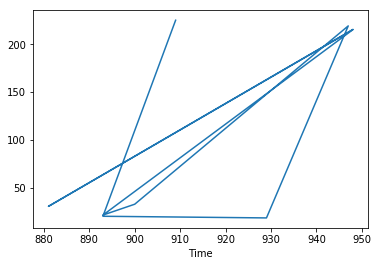

In [39]:
Temp1 = series['Temp1']
Temp1[1:10].plot()
pyplot.show()

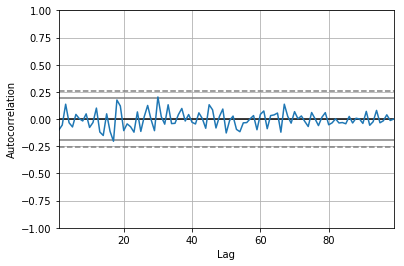

In [40]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(Temp1[1:100])
pyplot.show()

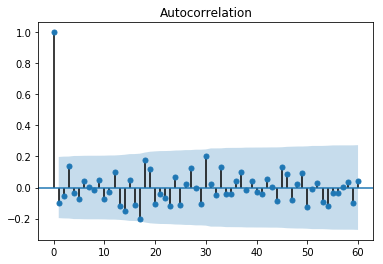

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Temp1[1:100], lags=60)
pyplot.show()

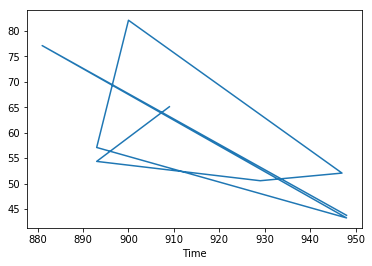

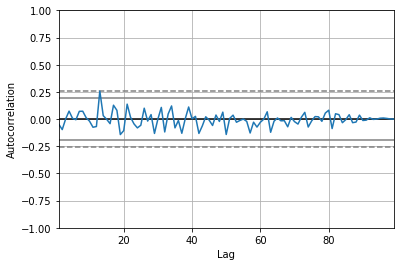

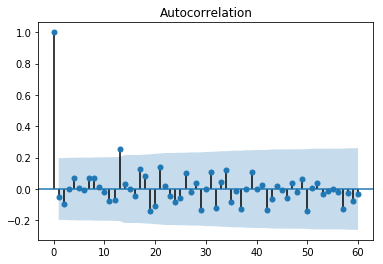

In [43]:
Temp2 = series['Temp2']
Temp2[1:10].plot()
pyplot.show()

autocorrelation_plot(Temp2[1:100])
pyplot.show()

plot_acf(Temp2[1:100], lags=60)
pyplot.show()

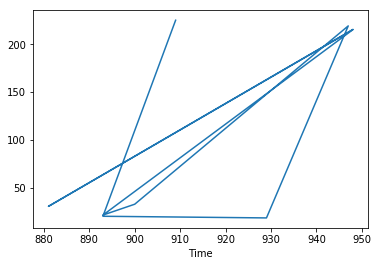

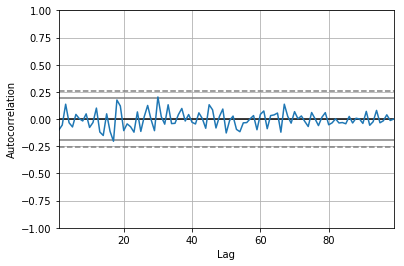

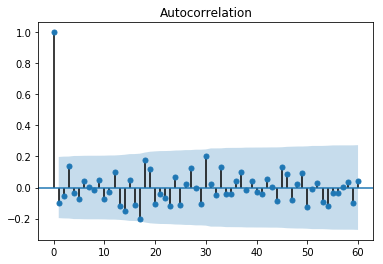

In [44]:
Temp3 = series['Temp3']
Temp3[1:10].plot()
pyplot.show()

autocorrelation_plot(Temp3[1:100])
pyplot.show()

plot_acf(Temp3[1:100], lags=60)
pyplot.show()

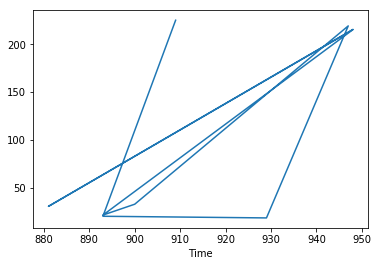

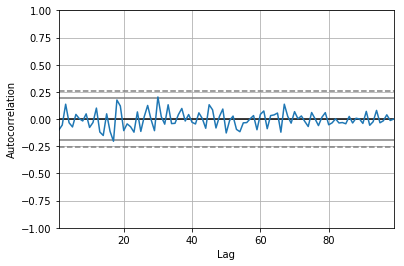

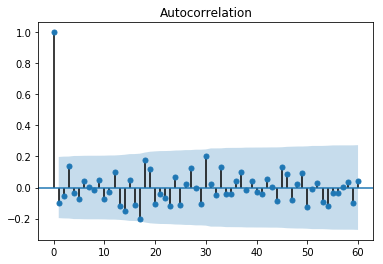

In [45]:
Temp_Ambient = series['Temp_Ambient']
Temp_Ambient[1:10].plot()
pyplot.show()

autocorrelation_plot(Temp_Ambient[1:100])
pyplot.show()

plot_acf(Temp_Ambient[1:100], lags=60)
pyplot.show()